In [70]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
from umap import umap_
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
import lightgbm as lgb
import shap


In [71]:
df = pd.read_csv('data/raw/new_retail_data.csv')

---
---

# CLEANING

---

### SELECT DATA

In [72]:
df = df.dropna(subset=['Transaction_ID','Customer_ID'])

In [73]:
df['Transaction_ID'] = df['Transaction_ID'].astype(int)
df['Customer_ID'] = df['Customer_ID'].astype(int)

In [74]:
columns = [
    'Transaction_ID',
    'Customer_ID',
    'State',
    'Country',
    'Age',
    'Gender',
    'Income',
    'Amount',
    'Total_Purchases',
    'Total_Amount',
    'Product_Category',
    'Product_Brand',
    'Product_Type',
    'Shipping_Method',
    'Payment_Method',
    'Ratings']

In [75]:
df_clean = df.copy()[columns]
df_clean = df_clean.dropna()
print(f"Lost {len(df)-len(df_clean)} rows. That is {(len(df)-len(df_clean))/len(df)*100} %")

Lost 3756 rows. That is 1.2463126598953442 %


---
### MAP THE VARIABLES

In [76]:
df_clean['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0)

In [77]:
to_replace = {
    'Low' : 1,
    'Medium': 2,
    'High' : 3 
}

df_clean['Income'] = df['Income'].map(to_replace)

---
### DUMMIFY

In [78]:
customer_columns = ['Customer_ID','Age','Gender','Income','State','Country']
transaction_columns = ['Transaction_ID','Customer_ID','Amount','Total_Purchases','Total_Amount','Ratings','Product_Category','Product_Brand','Product_Type','Shipping_Method','Payment_Method']

In [79]:
df_customer = df_clean[customer_columns].drop_duplicates(subset='Customer_ID')
df_transaction = df_clean[transaction_columns]

In [80]:
df_customer = pd.get_dummies(df_customer,columns=['State','Country'], drop_first=True, dtype=int)
df_transaction = pd.get_dummies(df_transaction,columns=['Product_Category','Product_Brand','Product_Type','Shipping_Method','Payment_Method'], drop_first=True, dtype=int)

---
### AGGREGATE TRANSACTIONS

In [81]:
avg_columns = ['Amount', 'Total_Purchases', 'Total_Amount', 'Ratings']
sum_columns = [col for col in df_transaction.columns if col not in avg_columns + ['Customer_ID', 'Transaction_ID']]

agg_dict = {col: 'mean' for col in avg_columns}
agg_dict.update({col: 'sum' for col in sum_columns})


In [82]:
df_aggregated = df_transaction.groupby('Customer_ID').agg(agg_dict).reset_index()

In [83]:
df_aggregated = df_aggregated.merge(df_customer,on='Customer_ID')

In [84]:
feature_columns = list(df_aggregated.columns)

In [85]:
df_sampled = df_aggregated.sample(n=10000, replace=False, random_state=42)

features = df_sampled.select_dtypes(include=['number']).drop(['Customer_ID'],axis=1)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

---
---
# DIMENSIONAL REDUCTION

In [86]:
# Perform UMAP for dimensionality reduction to 2 dimensions
umap_reducer = umap_.UMAP(n_components=3, random_state=42)
umap_data = umap_reducer.fit_transform(normalized_data)


C:\Users\UY641FU\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [87]:
df_sampled['UMAP1'] = umap_data[:,0]
df_sampled['UMAP2'] = umap_data[:,1]
df_sampled['UMAP3'] = umap_data[:,2]

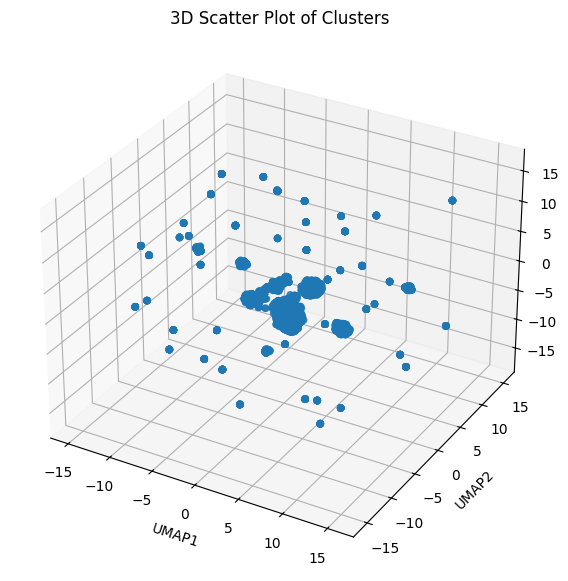

In [88]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  

# Create the scatter plot
scatter = ax.scatter(x, y, z, s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.savefig('artifacts/imgs/dimensional_reduction.png')

plt.show()

---

### remove density outliers

In [89]:
radius = 0.5  # Specify the radius to define the local neighborhood

# Extract features
features = df_sampled[['UMAP1', 'UMAP2', 'UMAP3']].values

# Fit the NearestNeighbors model
nbrs = NearestNeighbors(radius=radius).fit(features)

# Compute neighbors within the specified radius for each point
neighbors_count = nbrs.radius_neighbors(features, return_distance=False)

# Calculate local density as the number of neighbors (including the point itself)
local_density = np.array([len(neighbors) for neighbors in neighbors_count])

# Add the local density to the DataFrame
df_sampled['Local_Density'] = local_density
df_sampled['Q_Local_Density'] = pd.qcut(local_density,q=4, labels=[1, 2, 3, 4]).astype(int)

df_sampled = df_sampled.loc[df_sampled['Q_Local_Density'] > 1].copy()

features = df_sampled.select_dtypes(include=['number']).drop(['Customer_ID'],axis=1)

scaler = StandardScaler()
normalized_data = scaler.fit_transform(features)

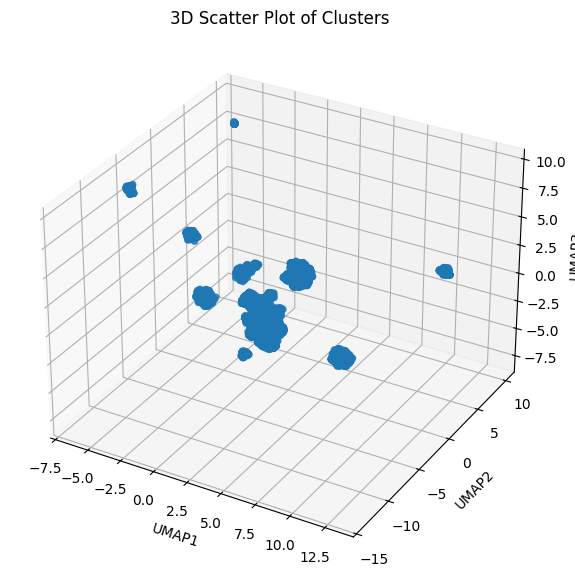

In [90]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  

# Create the scatter plot
scatter = ax.scatter(x, y, z, s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.savefig('artifacts/imgs/dimensional_reduction.png')

plt.show()

---
---

# CLUSTERING (no dimensional reduction)

---
### K-means Clustering

In [91]:
kmeans_labels = []
scores = []

for k in range(2,31,3):

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels += [ kmeans.fit_predict(normalized_data) ]

    labels = kmeans_labels[-1]

    df_sampled['label'] = labels

    kmeans_silhouette = silhouette_score(normalized_data, df_sampled['label'])
    print(f"Silhouette Score for KMeans Clustering with {k} clusters: {kmeans_silhouette:.2f}")

    scores += [kmeans_silhouette]

optimal = np.argmax(scores)+2
k = list(range(2,31,3))[optimal-2]

print(f"the optimal number of clusters is {optimal}, with a score of {scores[optimal-2]:.2f}")

Silhouette Score for KMeans Clustering with 2 clusters: 0.04
Silhouette Score for KMeans Clustering with 5 clusters: 0.02
Silhouette Score for KMeans Clustering with 8 clusters: 0.02
Silhouette Score for KMeans Clustering with 11 clusters: 0.04
Silhouette Score for KMeans Clustering with 14 clusters: 0.03
Silhouette Score for KMeans Clustering with 17 clusters: 0.03
Silhouette Score for KMeans Clustering with 20 clusters: 0.03
Silhouette Score for KMeans Clustering with 23 clusters: 0.03
Silhouette Score for KMeans Clustering with 26 clusters: 0.03
Silhouette Score for KMeans Clustering with 29 clusters: 0.04
the optimal number of clusters is 11, with a score of 0.04


In [92]:
# Assign K-means cluster labels to the DataFrame
df_sampled['KMeans_Cluster'] = kmeans_labels[optimal-2]

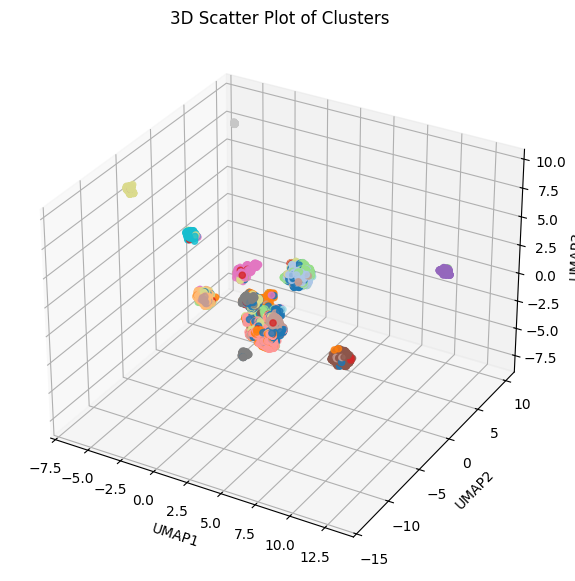

In [93]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['KMeans_Cluster']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.savefig('artifacts/imgs/clustering_KMEANS_noDimensionalReduction.png')

plt.show()


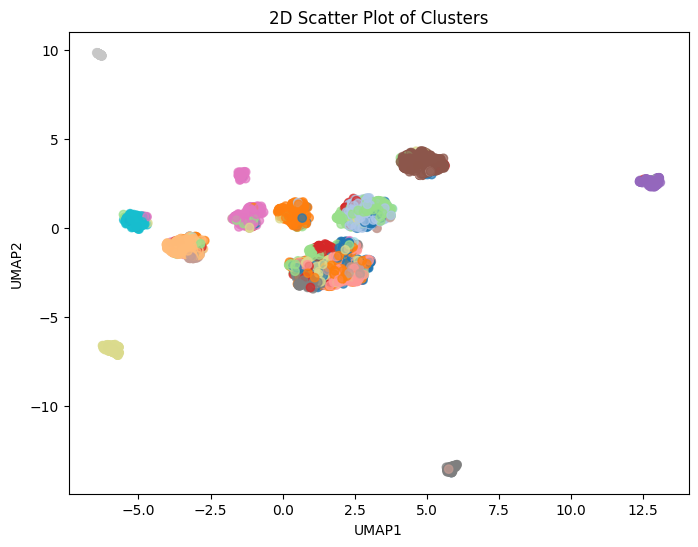

In [94]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['KMeans_Cluster'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


---
---

# CLUSTERING (*with* dimensional reduction)

---
### K-means Clustering

In [95]:
scores = []
kmeans_labels = []

for k in range(2,101,5):

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans_labels += [ kmeans.fit_predict(df_sampled[['UMAP1','UMAP2','UMAP3']]) ]

    labels = kmeans_labels[-1]

    df_sampled['label'] = labels

    kmeans_silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for KMeans Clustering with {k} clusters: {kmeans_silhouette:.2f}")

    scores += [kmeans_silhouette]

optimal = np.argmax(scores)+2
k = list(range(2,101,5))[optimal-2]


print(f"the optimal number of clusters is {k}, with a score of {scores[optimal-2]:.2f}")

Silhouette Score for KMeans Clustering with 2 clusters: 0.36
Silhouette Score for KMeans Clustering with 7 clusters: 0.59
Silhouette Score for KMeans Clustering with 12 clusters: 0.72
Silhouette Score for KMeans Clustering with 17 clusters: 0.63
Silhouette Score for KMeans Clustering with 22 clusters: 0.53
Silhouette Score for KMeans Clustering with 27 clusters: 0.52
Silhouette Score for KMeans Clustering with 32 clusters: 0.48
Silhouette Score for KMeans Clustering with 37 clusters: 0.49
Silhouette Score for KMeans Clustering with 42 clusters: 0.50
Silhouette Score for KMeans Clustering with 47 clusters: 0.51
Silhouette Score for KMeans Clustering with 52 clusters: 0.47
Silhouette Score for KMeans Clustering with 57 clusters: 0.45
Silhouette Score for KMeans Clustering with 62 clusters: 0.46
Silhouette Score for KMeans Clustering with 67 clusters: 0.46
Silhouette Score for KMeans Clustering with 72 clusters: 0.46
Silhouette Score for KMeans Clustering with 77 clusters: 0.45
Silhouette

In [96]:
# Assign K-means cluster labels to the DataFrame
df_sampled['KMeans_Cluster_UMAP'] = kmeans_labels[optimal - 2]


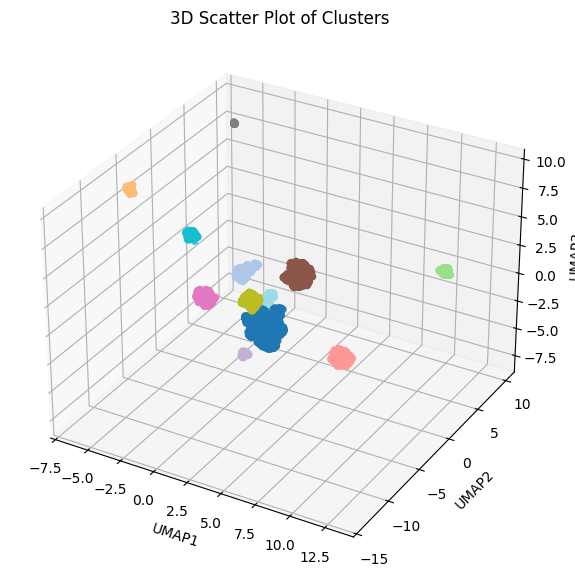

In [97]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['KMeans_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.savefig('artifacts/imgs/clustering_KMEANS_dimensionalReduction.png')

plt.show()


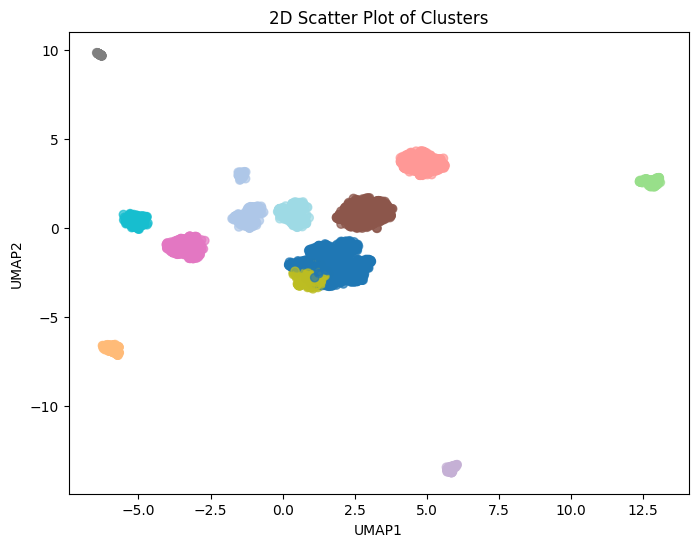

In [98]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['KMeans_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


---

# HIERARCHICAL

In [99]:
hierarchical_labels = []
scores = []

data_to_cluster = df_sampled[['UMAP1', 'UMAP2', 'UMAP3']]

for k in range(2,101,5):

    hierarchical = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
    hierarchical_labels += [hierarchical.fit_predict(data_to_cluster)]

    labels = hierarchical_labels[-1]

    df_sampled['label'] = labels

    silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for Hierarchical Clustering with {k} clusters: {silhouette:.2f}")

    scores += [silhouette]

optimal = np.argmax(scores)+2
k = list(range(2,101,5))[optimal-2]

print(f"the optimal number of clusters is {k}, with a score of {scores[optimal-2]:.2f}")


Silhouette Score for Hierarchical Clustering with 2 clusters: 0.49
Silhouette Score for Hierarchical Clustering with 7 clusters: 0.58
Silhouette Score for Hierarchical Clustering with 12 clusters: 0.72
Silhouette Score for Hierarchical Clustering with 17 clusters: 0.70
Silhouette Score for Hierarchical Clustering with 22 clusters: 0.63
Silhouette Score for Hierarchical Clustering with 27 clusters: 0.56
Silhouette Score for Hierarchical Clustering with 32 clusters: 0.53
Silhouette Score for Hierarchical Clustering with 37 clusters: 0.48
Silhouette Score for Hierarchical Clustering with 42 clusters: 0.49
Silhouette Score for Hierarchical Clustering with 47 clusters: 0.49
Silhouette Score for Hierarchical Clustering with 52 clusters: 0.49
Silhouette Score for Hierarchical Clustering with 57 clusters: 0.50
Silhouette Score for Hierarchical Clustering with 62 clusters: 0.50
Silhouette Score for Hierarchical Clustering with 67 clusters: 0.47
Silhouette Score for Hierarchical Clustering with 

In [100]:
df_sampled['Hierarchical_Cluster_UMAP'] = hierarchical_labels[optimal - 2]


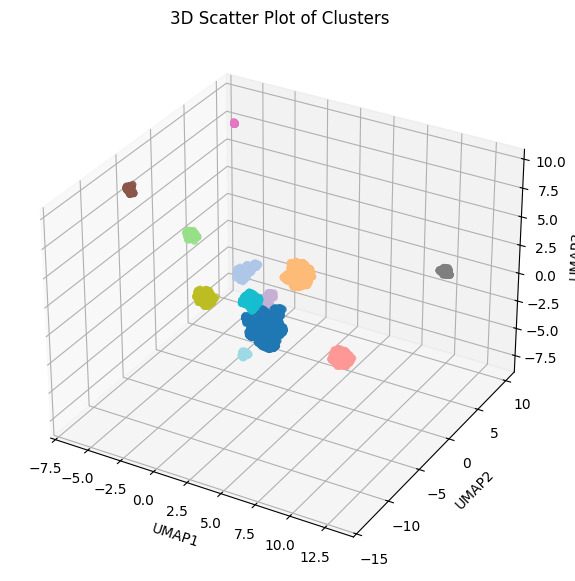

In [101]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['Hierarchical_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.savefig('artifacts/imgs/clustering_hierarchical_dimensionalReduction.png')

plt.show()

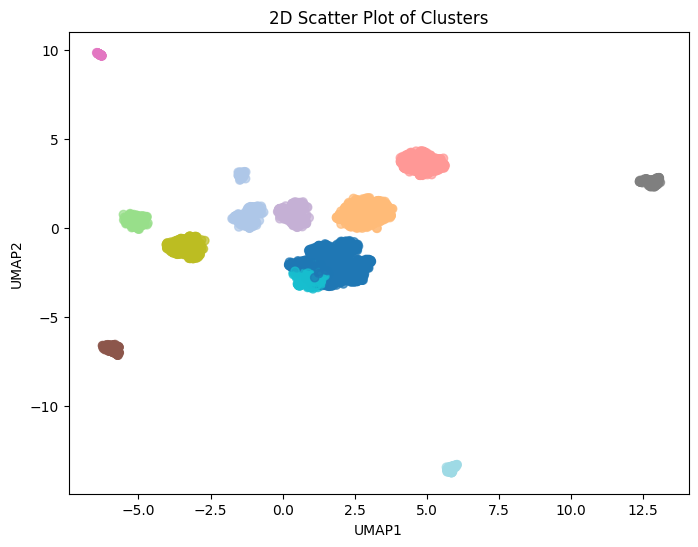

In [102]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['Hierarchical_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

---

# DBSCAN

In [103]:
dbscan_labels = []
scores = []

data_to_cluster = df_sampled[['UMAP1', 'UMAP2', 'UMAP3']]

for scale in np.linspace(0.1,5,20)[::-1]:

    dbscan = DBSCAN(eps=scale, min_samples=10)  # Adjust eps and min_samples as needed
    dbscan_labels += [dbscan.fit_predict(data_to_cluster)]

    labels = dbscan_labels[-1]

    df_sampled['label'] = labels

    k = len(df_sampled['label'].unique())

    silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for DBSCAN Clustering with {k} clusters (eps = {scale:.2f}): {silhouette:.2f}")

    scores += [silhouette]

optimal = np.argmax(scores)

df_sampled['DBSCAN_Cluster_UMAP'] = dbscan_labels[optimal]
k = len(df_sampled['DBSCAN_Cluster_UMAP'].unique())

print(f"the optimal number of clusters is {k}, with a score of {scores[optimal]:.2f}")


Silhouette Score for DBSCAN Clustering with 6 clusters (eps = 5.00): 0.61
Silhouette Score for DBSCAN Clustering with 6 clusters (eps = 4.74): 0.61
Silhouette Score for DBSCAN Clustering with 6 clusters (eps = 4.48): 0.61
Silhouette Score for DBSCAN Clustering with 6 clusters (eps = 4.23): 0.61
Silhouette Score for DBSCAN Clustering with 6 clusters (eps = 3.97): 0.61
Silhouette Score for DBSCAN Clustering with 6 clusters (eps = 3.71): 0.61
Silhouette Score for DBSCAN Clustering with 7 clusters (eps = 3.45): 0.56
Silhouette Score for DBSCAN Clustering with 7 clusters (eps = 3.19): 0.56
Silhouette Score for DBSCAN Clustering with 7 clusters (eps = 2.94): 0.56
Silhouette Score for DBSCAN Clustering with 7 clusters (eps = 2.68): 0.56
Silhouette Score for DBSCAN Clustering with 7 clusters (eps = 2.42): 0.56
Silhouette Score for DBSCAN Clustering with 8 clusters (eps = 2.16): 0.56
Silhouette Score for DBSCAN Clustering with 8 clusters (eps = 1.91): 0.56
Silhouette Score for DBSCAN Clustering

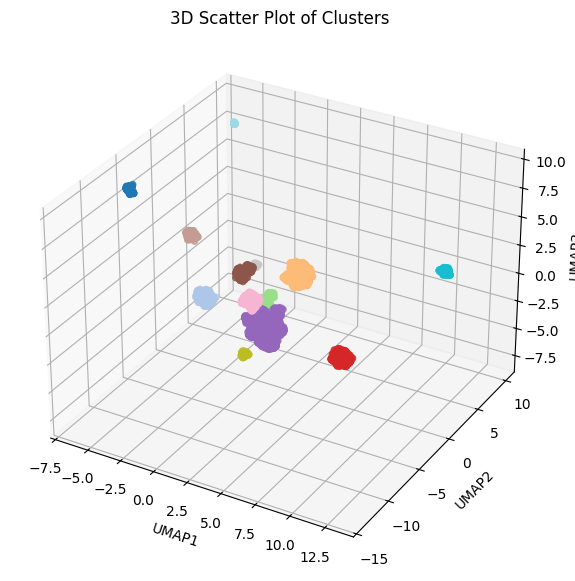

In [104]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['DBSCAN_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.savefig('artifacts/imgs/clustering_DBSCAN_dimensionalReduction.png')

plt.show()

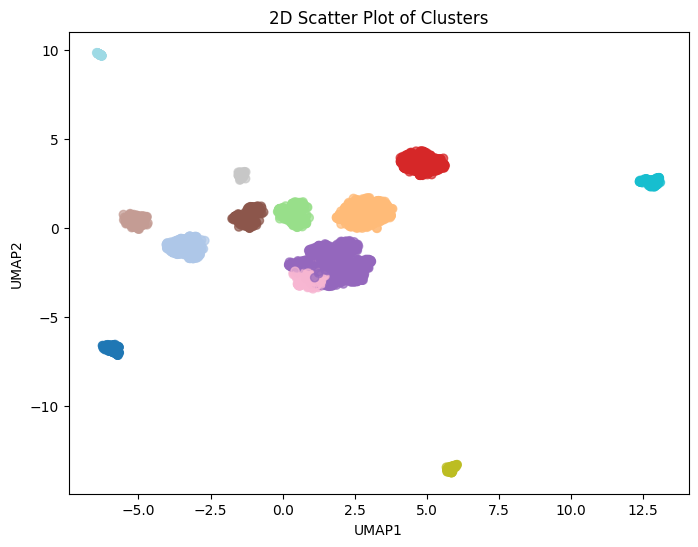

In [105]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['DBSCAN_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

---

### GAUSSIAN MIXTURES

In [106]:
gaussian_labels = []
scores = []

data_to_cluster = df_sampled[['UMAP1', 'UMAP2', 'UMAP3']]


for k in range(2,101,5):

    gmm = GaussianMixture(n_components=k, random_state=42)  # Adjust n_components as needed
    gaussian_labels += [gmm.fit_predict(data_to_cluster)]

    labels = gaussian_labels[-1]

    df_sampled['label'] = labels

    silhouette = silhouette_score(df_sampled[['UMAP1','UMAP2','UMAP3']], df_sampled['label'])
    print(f"Silhouette Score for Gaussian Mixures with {k} gaussians: {silhouette:.2f}")

    scores += [silhouette]

optimal = np.argmax(scores)+2
k = list(range(2,101,5))[optimal-2]

print(f"the optimal number of clusters is {k}, with a score of {scores[optimal-2]:.2f}")

Silhouette Score for Gaussian Mixures with 2 gaussians: 0.39
Silhouette Score for Gaussian Mixures with 7 gaussians: 0.57
Silhouette Score for Gaussian Mixures with 12 gaussians: 0.72
Silhouette Score for Gaussian Mixures with 17 gaussians: 0.64
Silhouette Score for Gaussian Mixures with 22 gaussians: 0.53
Silhouette Score for Gaussian Mixures with 27 gaussians: 0.52
Silhouette Score for Gaussian Mixures with 32 gaussians: 0.47
Silhouette Score for Gaussian Mixures with 37 gaussians: 0.49
Silhouette Score for Gaussian Mixures with 42 gaussians: 0.48
Silhouette Score for Gaussian Mixures with 47 gaussians: 0.49
Silhouette Score for Gaussian Mixures with 52 gaussians: 0.43
Silhouette Score for Gaussian Mixures with 57 gaussians: 0.42
Silhouette Score for Gaussian Mixures with 62 gaussians: 0.41
Silhouette Score for Gaussian Mixures with 67 gaussians: 0.42
Silhouette Score for Gaussian Mixures with 72 gaussians: 0.41
Silhouette Score for Gaussian Mixures with 77 gaussians: 0.41
Silhouette

In [107]:
df_sampled['Gaussian_Cluster_UMAP'] = gaussian_labels[optimal-2]


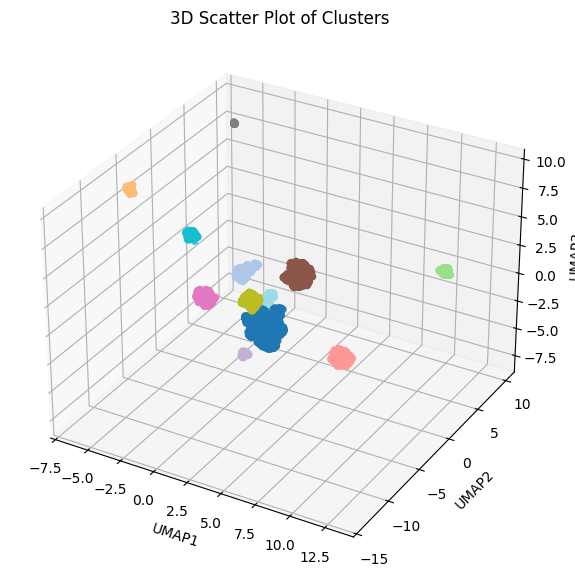

In [108]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['Gaussian_Cluster_UMAP']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')  

plt.savefig('artifacts/imgs/clustering_gaussian_dimensionalReduction.png')

plt.show()

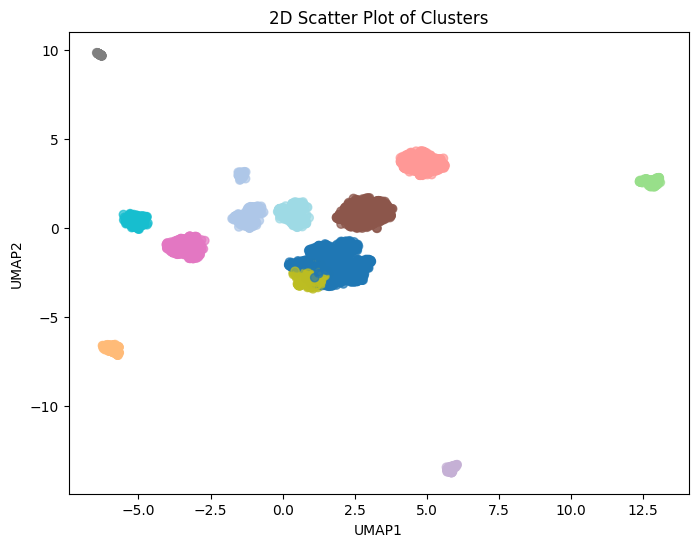

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(df_sampled['UMAP1'], df_sampled['UMAP2'], c=df_sampled['Gaussian_Cluster_UMAP'], cmap='tab20', alpha=0.7)
plt.title('2D Scatter Plot of Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

---

### CUSTOMER SEGMENT

In [110]:
df_sampled = df_sampled.merge(df[['Customer_ID','Customer_Segment']].drop_duplicates(subset=['Customer_ID']),on='Customer_ID',how='left')

In [111]:
to_replace = {
    'Regular' : 2,
    'Premium' : 3,
    'New' : 1
}

df_sampled['Customer_Segment_encoded'] = df_sampled['Customer_Segment'].map(to_replace)
df_sampled['Customer_Segment_encoded'] = df_sampled['Customer_Segment_encoded'].fillna(0)


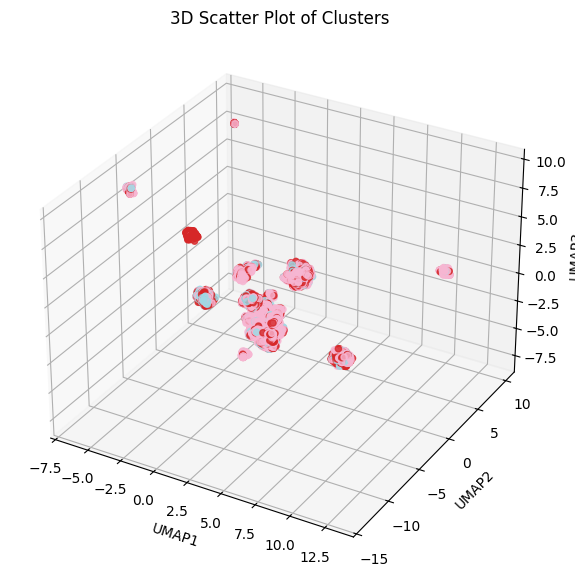

In [112]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['Customer_Segment_encoded']  # Use clustering labels for coloring

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=20, alpha=0.8)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

plt.savefig('artifacts/imgs/clustering_customerSegments.png')

plt.show()


---
---

# SAVE OUTPUTS

---

### UNDUMMIFY

In [113]:
df_customer = df_clean[customer_columns].drop_duplicates(subset='Customer_ID')
df_transaction = df_clean[transaction_columns]

In [114]:
df_transaction = pd.get_dummies(df_transaction,columns=['Product_Category','Product_Brand','Product_Type','Shipping_Method','Payment_Method'], drop_first=False, dtype=int)

In [115]:
df_aggregated_ = df_transaction.groupby('Customer_ID').agg(agg_dict).reset_index()
df_aggregated_ = df_aggregated_.merge(df_customer,on='Customer_ID')

In [116]:
df_sampled['Cluster'] = df_sampled['Hierarchical_Cluster_UMAP']

In [117]:
df_aggregated_ = df_aggregated_.merge(df_sampled[['Customer_ID','Cluster','UMAP1','UMAP2','UMAP3']],on='Customer_ID')

In [118]:
# Save the DataFrame with the new column
df_aggregated_.to_csv('data/processed/new_retail_customer_clustering.csv', index=False)

---
---

# Explain Clusters

In [119]:
df_sampled_ = df_sampled[feature_columns + ['Cluster']]

In [120]:
X = df_sampled_.drop(['Customer_ID','Cluster'],axis=1)
y = df_sampled_['Cluster'].astype(str)

# We create the LGBMClassifier model and train it
clf_km = lgb.LGBMClassifier(colsample_by_tree=0.8)
clf_km.fit(X=X, y=y)

[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: colsample_by_tree
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 7464, number of used features: 78
[LightGBM] [Info] Start training from score -1.213486
[LightGBM] [Info] Start training from score -2.713289
[LightGBM] [Info] Start training from score -2.554819
[LightGBM] [Info] Start training from score -3.741697
[LightGBM] [Info] Start training from score -2.051956
[LightGBM] [Info] Start training from score -2.936433
[LightGBM] [Info] Start training from score -2.172610
[LightGBM] [Info] Start training from score -2.760868
[LightGBM] [Info] St

LGBMClassifier(colsample_by_tree=0.8)

In [121]:
#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km(X)

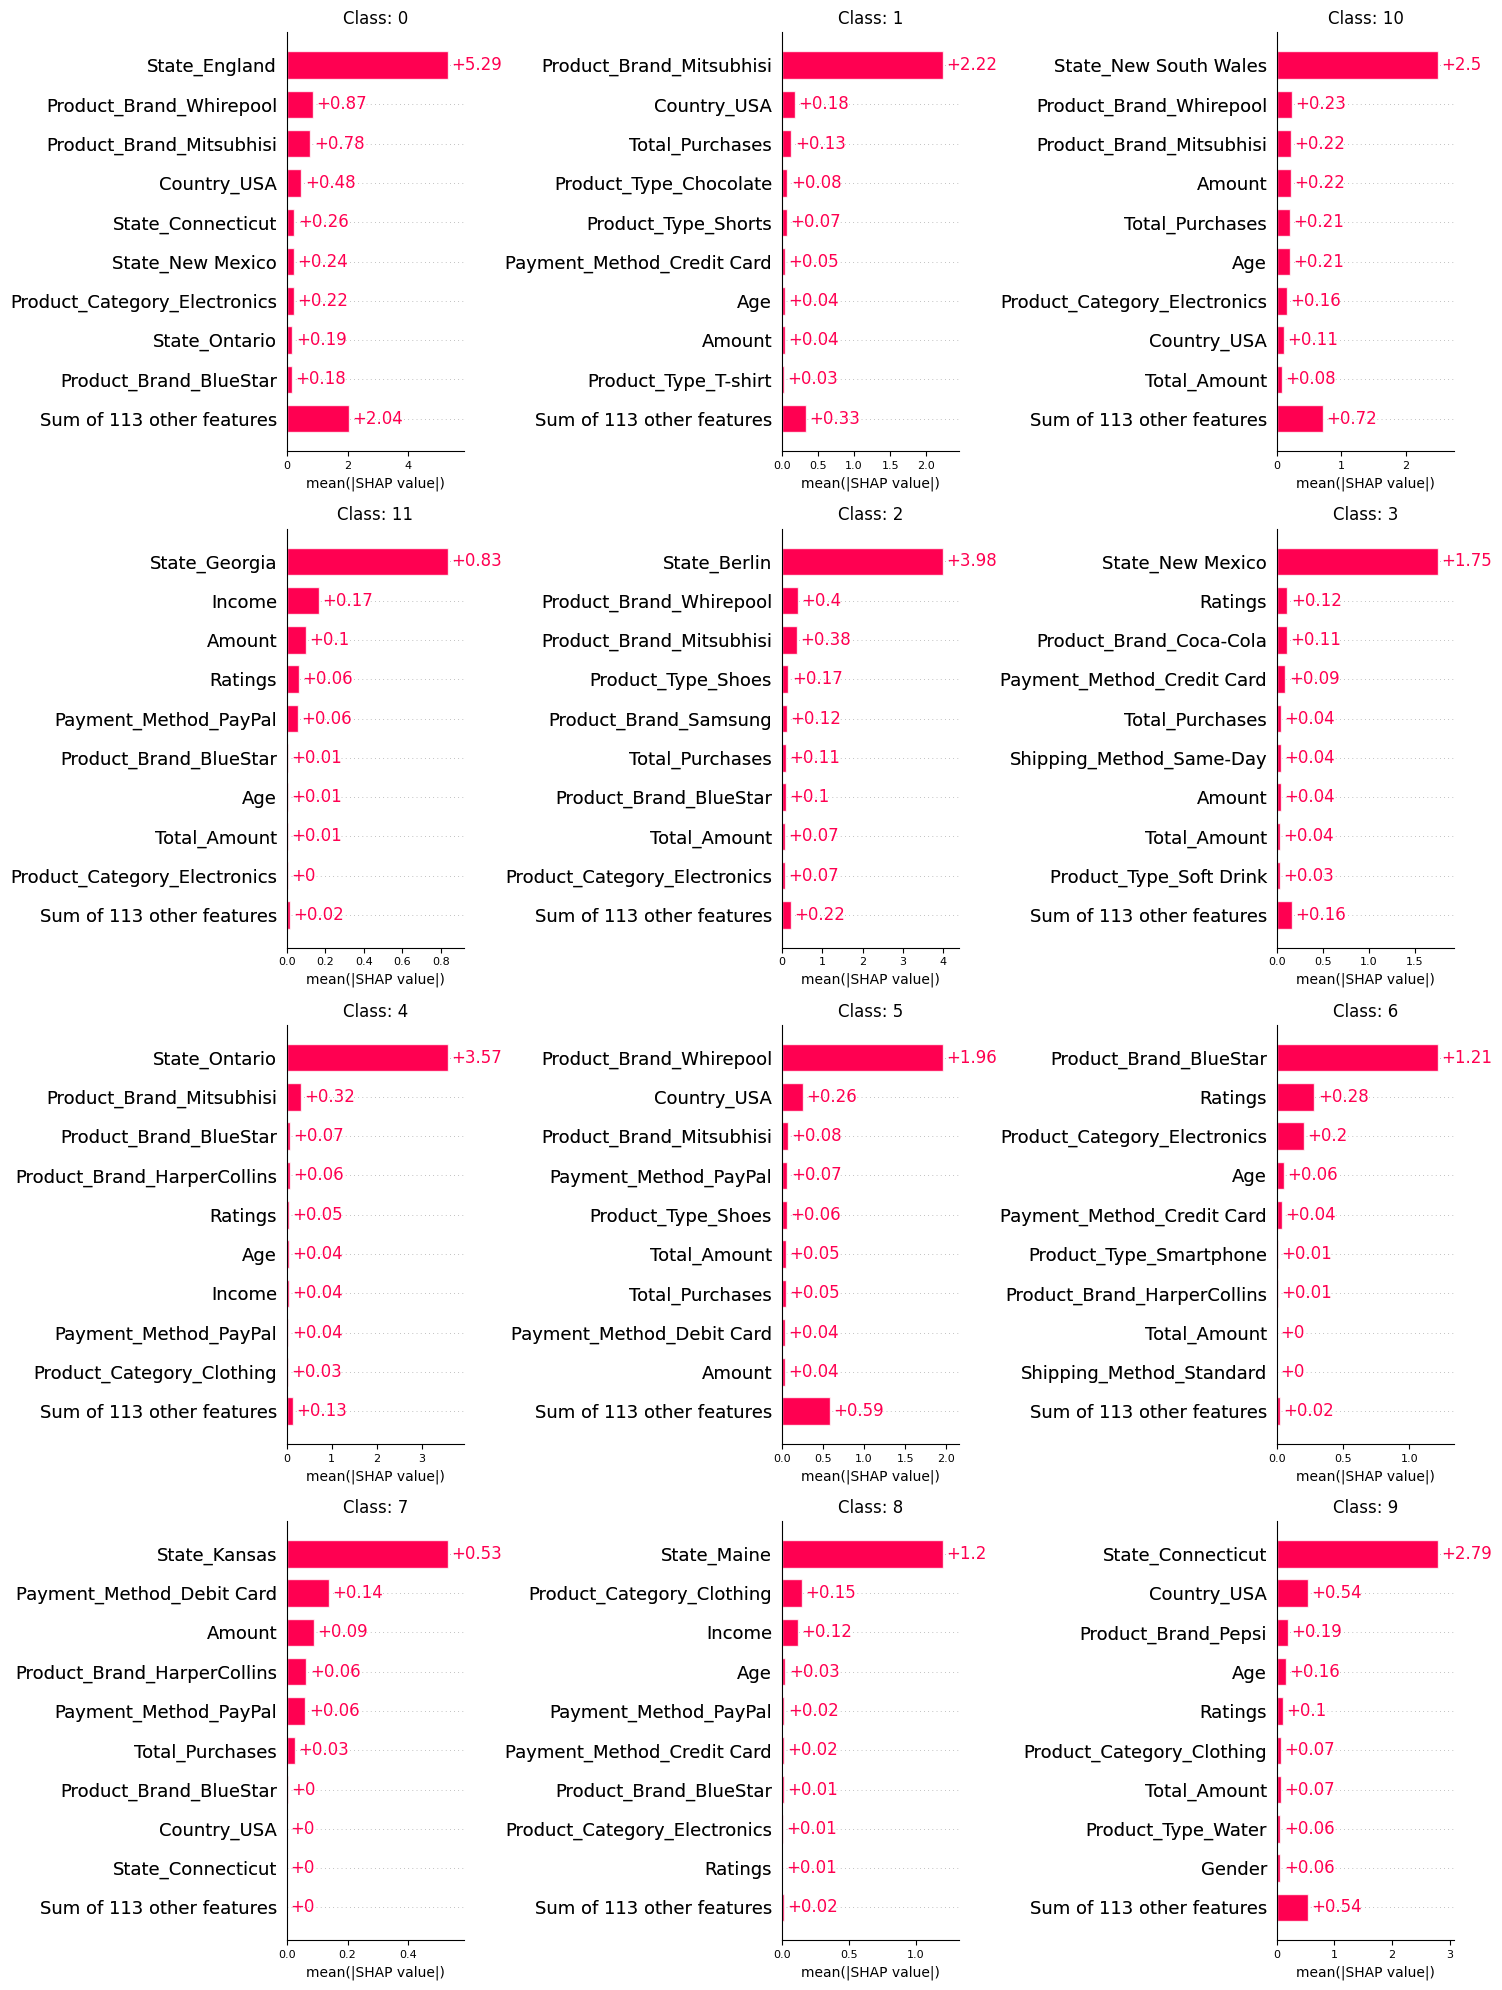

In [122]:
# Assuming clf_km.classes_ contains the class names (strings)
class_names = clf_km.classes_  # List of class names, e.g., ['class1', 'class2', ..., 'class12']

# Create a grid of subplots (4 rows x 3 columns for 12 classes)
fig, axes = plt.subplots(4, 3, figsize=(15, 20))  # Adjust figsize for readability
axes = axes.flatten()  # Flatten the 2D array of axes to loop over

# Iterate over each class and create the bar plot
for k, ax in enumerate(axes):
    if k < len(class_names):  # Avoid extra subplots if class_names < 12
        shap.plots.bar(shap_values_km[:, :, k], show=False, ax=ax)  # Bar plot for class k
        ax.set_title(f"Class: {class_names[k]}")  # Set the title as the class name
        # Make the x-axis labels smaller
        ax.tick_params(axis='x', labelsize=8)  # Reduce x-axis label font size (e.g., 8)
        ax.set_xlabel("mean(|SHAP value|)", fontsize=10)
    else:
        ax.axis('off')  # Turn off any unused subplot

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [123]:
cluster_names = {
    '0' : 'English Customers',
    '1': 'Mitsubhisi Lovers',
    '2': 'Berliners Customers',
    '3': 'New Mexican Customers',
    '4': 'Ontario Customers',
    '5': 'Whirepool Lovers',
    '6': 'Bluestar Lovers',
    '7': 'Kansas Customers',
    '8': 'Maine Customers',
    '9': 'Connetticut Customers',  
    '10': 'New South Wales Customers',
    '11': 'Georgia Customers',
}

df_sampled['Cluster_Name'] = df_sampled['Cluster'].astype(str).replace(cluster_names)

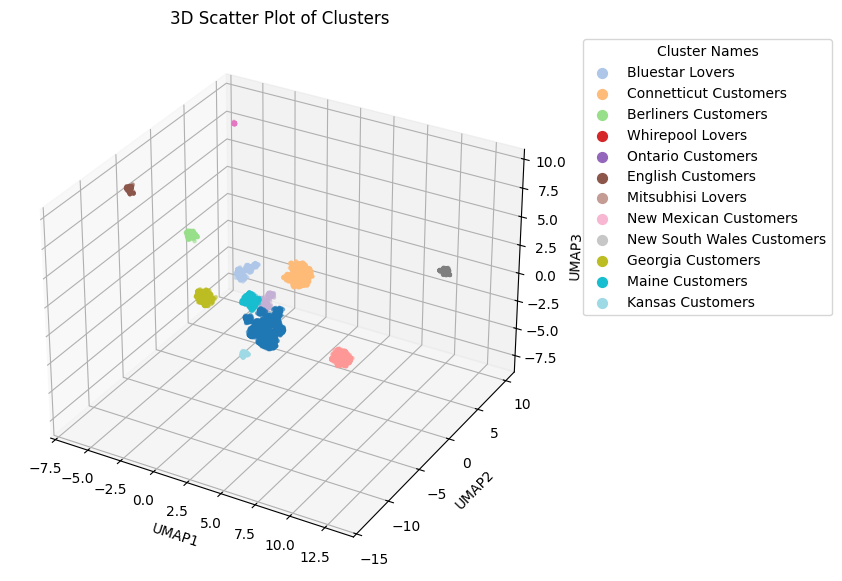

In [124]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['Cluster']  # This contains the cluster number for each point
cluster_names = df_sampled['Cluster_Name'].unique()  # Extract unique cluster names

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=5, alpha=0.5)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Create a custom legend
# We will create a scatter plot with one point per cluster and associate it with its name
for i, cluster_name in enumerate(cluster_names):
    ax.scatter([], [], [], c=[plt.cm.tab20((i+1)/len(cluster_names))], label=cluster_name, s=50)

# Add legend
ax.legend(title="Cluster Names", bbox_to_anchor=(1.05, 1), loc='upper left')

# Save and show the plot
plt.savefig('artifacts/imgs/clustering_customerSegments.png', bbox_inches='tight')
plt.show()

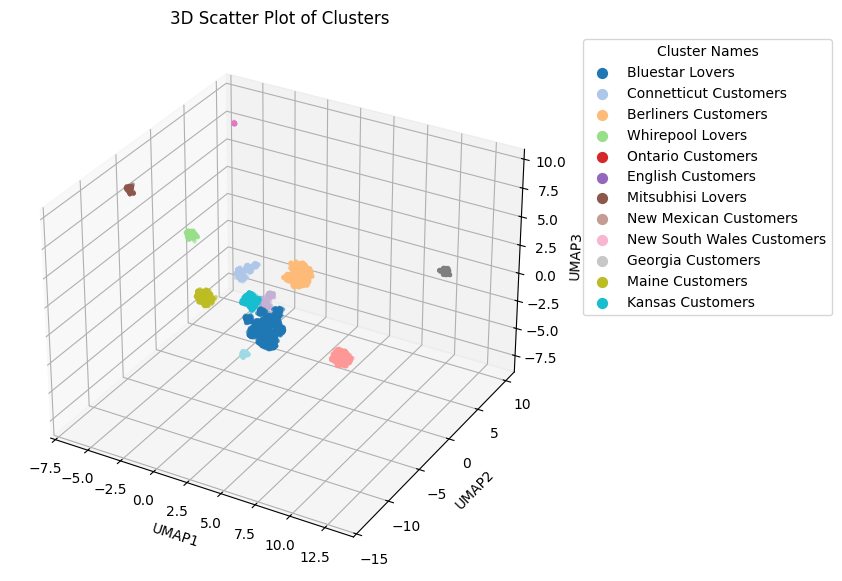

In [125]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = df_sampled['UMAP1']  
y = df_sampled['UMAP2']  
z = df_sampled['UMAP3']  
labels = df_sampled['Cluster']  # This contains the cluster number for each point
cluster_names = df_sampled['Cluster_Name'].unique()  # Extract unique cluster names

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=labels, cmap='tab20', s=5, alpha=0.5)

# Label axes
ax.set_title('3D Scatter Plot of Clusters')
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')

# Create a custom legend
# We will create a scatter plot with one point per cluster and associate it with its name
for i, cluster_name in enumerate(cluster_names):
    ax.scatter([], [], [], c=[plt.cm.tab20(i/len(cluster_names))], label=cluster_name, s=50)

# Add legend
ax.legend(title="Cluster Names", bbox_to_anchor=(1.05, 1), loc='upper left')

# Save and show the plot
plt.savefig('artifacts/imgs/clustering_customerSegments.png', bbox_inches='tight')
plt.show()